### 경남 창원시, 김해시 문화 공급/수요/접근성 현황 분석

#### 1. 분석 목적

창원시와 김해시를 중심으로 문화시설 공급 현황, 문화 소비 수요, 그리고 공간적 접근성을 통합적으로 파악함으로써 지역 간 문화 형평성 및 정책적 개선 필요 지점을 도출하는 것을 목적

---

#### 2. 분석 대상 항목

| 항목     | 주요 내용                                  | 분석 목적                                |
|----------|---------------------------------------------|-------------------------------------------|
| 문화 공급 | 공연장, 문화회관, 박물관 등 시설의 위치 및 수량 | 지역 간 문화시설 분포 및 밀도 비교        |
| 문화 수요 | 인구통계, 문화소비 카드데이터, 연령별 인구 등 | 소비 특성과 인구 기반 수요 분석           |
| 접근성    | 대중교통 정류장, 도보 반경, 도로망 등        | 문화시설 접근 가능성 및 공간적 형평성 평가 |

---

#### 3. 분석 설계 흐름

##### 3.1 문화 공급 분석
- 문화시설 분포 및 유형별 통계
- 시군구 단위 시설 개수 및 밀도 분석
- 시설 위치 기반 지도 시각화 (Folium)

##### 3.2 문화 수요 분석
- 인구 및 연령대 기반 수요 예측
- 신용카드 문화소비 데이터 분석
- 인구당 문화소비액, 월별 트렌드 분석
- 수요 중심지 군집화 (KMeans, UMAP 등)

##### 3.3 접근성 분석 (GIS 기반)
- 대중교통 정류장과의 거리 계산 (500m buffer)
- 시설 접근성 평가 (정류장 수, 도보 반경)
- 시설별 서비스 가능 인구수 추정

---

#### 4. 심화 분석

##### 4.1 문화소비 패턴 클러스터링
- GMM, DBSCAN, SOM을 통한 지역별 소비 행태 군집화
- UMAP 기반 2D 시각화

##### 4.2 문화 형평성 지표 개발
- 시설수 / 인구수, 소비액 / 인구 등 문화 불균형 지표 산출
- 문화서비스지수: 공급 × 수요 × 접근성의 통합 스코어

##### 4.3 대시보드 구성 (선택)
- Folium을 이용한 시군구 대시보드 구현
- 시설정보, 소비현황, 접근성 지표의 시각적 통합

---

#### 5. 기대 효과

- 지역별 문화 인프라의 격차를 정량적으로 진단
- 문화시설 신설 및 개편에 대한 정책적 우선순위 제안
- 인구 특성과 접근성을 고려한 수요지 중심 맞춤 전략 도출

In [6]:
# import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import networkx as nx
import os

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'

In [90]:
#path

culture = r"D:\MINNIE\contest_gyeongnam_data_analysis\data_for_dashboard\geocoding_culture_data.xlsx"
gn_map = r"D:\MINNIE\contest_gyeongnam_data_analysis\data_for_dashboard\GN_map.geojson"
acc = r"D:\MINNIE\contest_gyeongnam_data_analysis\data\접근성.csv"
ppl = r"D:\MINNIE\contest_gyeongnam_data_analysis\data_for_dashboard\경상남도+분기별+생활인구+현황.csv"
ppl_c = r"D:\MINNIE\contest_gyeongnam_data_analysis\data_for_dashboard\생활인구데이터셋\생활인구데이터셋\23년도 경남 생활인구 데이터.csv"

### 문화 공급 분석
 - 문화시설별 개수 및 수량 분석

In [24]:
df_culture = pd.read_excel(culture)
df_culture.head(5)

,Unnamed: 0,시군구,소재지,Latitude,Longitude,구분
0,2,산청군,산청군 금서면 친환경로2631번길 12,35.420126,127.872855,문화예술회관
1,7,의령군,의령군 의령읍 의병로24길 31-1,35.317694,128.264840,문화예술회관
2,10,김해시,김해시 김해대로 2062 (내동),35.242477,128.863187,문화예술회관
3,13,창원시,창원시 진해구 진해대로 325 (태백동),35.169833,128.666084,문화예술회관
4,14,창원시,창원시 마산회원구 삼호로 135,35.225855,128.577258,문화예술회관


In [25]:
df_culture_big = df_culture[df_culture['시군구'].isin(['창원시', '김해시'])]

In [26]:
# 문화시설별 개수
culture_cnt = df_culture_big.groupby(["시군구", "구분"])['소재지'].count().reset_index()

In [27]:
culture_cnt

,시군구,구분,소재지
0,김해시,공연장,13
1,김해시,문화예술회관,1
2,김해시,미술관,1
3,김해시,박물관,3
4,김해시,유원시설업(기타),31
5,김해시,일반유원시설업,4
6,김해시,전문휴양업,1
7,김해시,종합유원시설업,2
8,김해시,종합휴양업,1
9,창원시,공연장,18


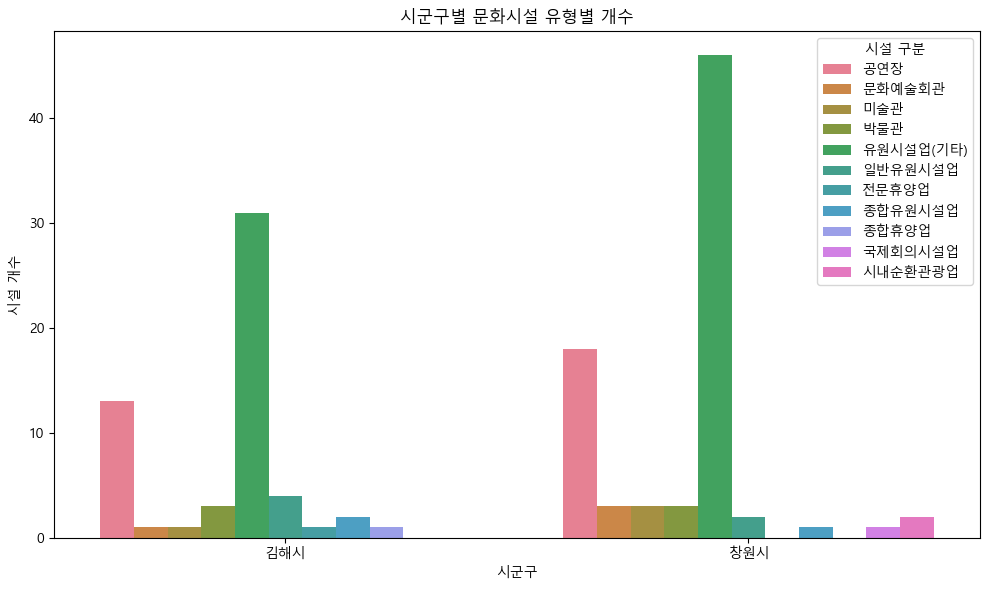

In [29]:
# 그래프
plt.figure(figsize=(10, 6))
sns.barplot(data=culture_cnt, x='시군구', y='소재지', hue='구분')
plt.title('시군구별 문화시설 유형별 개수')
plt.ylabel('시설 개수')
plt.xlabel('시군구')
plt.legend(title='시설 구분')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17916\3680884298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_culture_big['geometry'] = df_culture_big.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)


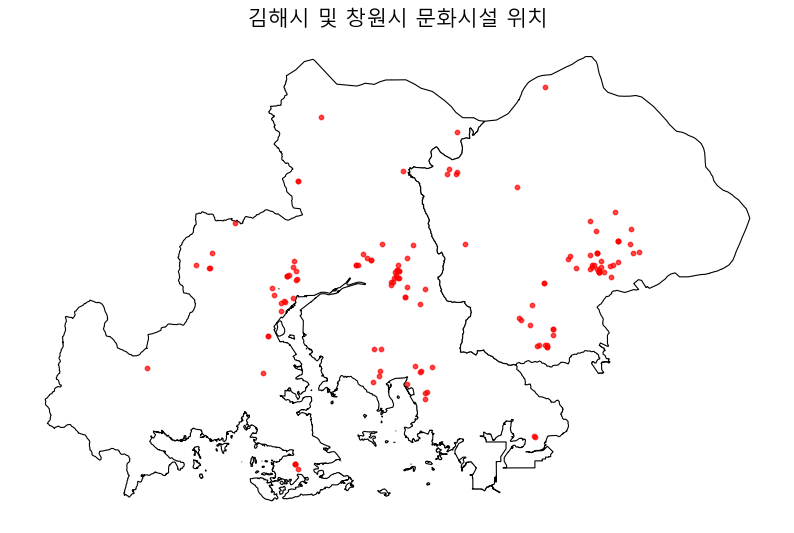

In [40]:
# 좌표 표시
gdf_map = gpd.read_file(gn_map) 
gdf_map = gdf_map.to_crs(epsg=4326)  

target_regions = ['경상남도 김해시', '경상남도 창원시']
gdf_map_filtered = gdf_map[gdf_map['SGG_NM'].isin(target_regions)]

df_culture_big['geometry'] = df_culture_big.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_facility = gpd.GeoDataFrame(df_culture_big, geometry='geometry', crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(10, 10))
gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
gdf_facility.plot(ax=ax, color='red', markersize=10, alpha=0.7)

ax.set_title('김해시 및 창원시 문화시설 위치', fontsize=15)
ax.axis('off')
plt.show()

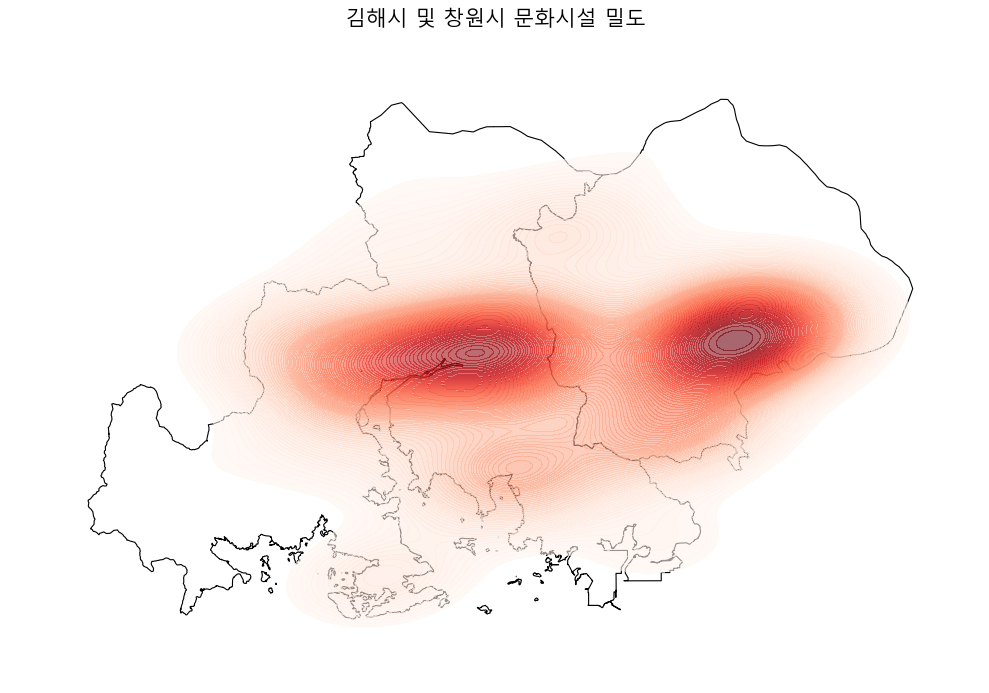

In [41]:
# 열지도
x = gdf_facility['Longitude']
y = gdf_facility['Latitude']

fig, ax = plt.subplots(figsize=(10, 10))
gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
sns.kdeplot(x=x, y=y, ax=ax, cmap="Reds", fill=True, alpha=0.6, thresh=0.05, levels=100)

ax.set_title('김해시 및 창원시 문화시설 밀도', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()

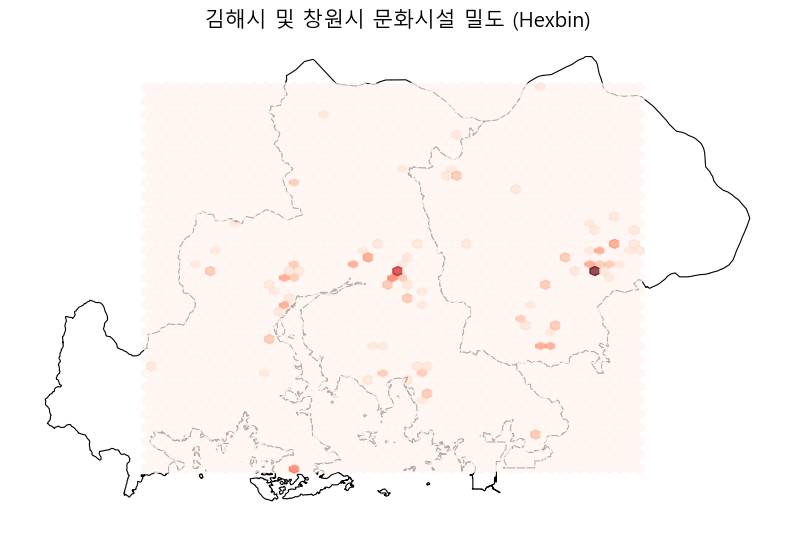

In [42]:
# 열지도 v2
fig, ax = plt.subplots(figsize=(10, 10))
gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
ax.hexbin(x, y, gridsize=50, cmap='Reds', alpha=0.7)
ax.set_title('김해시 및 창원시 문화시설 밀도 (Hexbin)', fontsize=15)
ax.axis('off')
plt.show()

### 문화시설 접근성 분석
 - 문화시설 반경 500m 이내의 버스정류장, 주차장, 지하철역, 자전거 정류장 시각화 및 거리 계산

In [50]:
acc = pd.read_csv(acc, encoding='euc-kr',  sep='\t')
acc

,시군구명,접근성 변수명,위도,경도
0,창원시,버스정류장_구암고등학교,35.246296,128.593978
1,창원시,버스정류장_사격장입구,35.244923,128.683156
2,창원시,버스정류장_장애인복지회관입구,35.244960,128.673597
3,창원시,버스정류장_장애인복지회관입구,35.244773,128.673243
4,창원시,버스정류장_지귀상가,35.244778,128.659437
...,...,...,...,...
6920,김해시,지하철_부산김해경전철 수로왕릉,35.232822,128.872141
6921,김해시,지하철_부산김해경전철 연지공원,35.249658,128.869291
6922,김해시,지하철_부산김해경전철 인제대,35.228099,128.901736
6923,김해시,지하철_부산김해경전철 장신대,35.259556,128.867114


In [51]:
acc_data = acc[acc["시군구명"].isin(["창원시", "김해시"])]
acc_data

,시군구명,접근성 변수명,위도,경도
0,창원시,버스정류장_구암고등학교,35.246296,128.593978
1,창원시,버스정류장_사격장입구,35.244923,128.683156
2,창원시,버스정류장_장애인복지회관입구,35.244960,128.673597
3,창원시,버스정류장_장애인복지회관입구,35.244773,128.673243
4,창원시,버스정류장_지귀상가,35.244778,128.659437
...,...,...,...,...
6920,김해시,지하철_부산김해경전철 수로왕릉,35.232822,128.872141
6921,김해시,지하철_부산김해경전철 연지공원,35.249658,128.869291
6922,김해시,지하철_부산김해경전철 인제대,35.228099,128.901736
6923,김해시,지하철_부산김해경전철 장신대,35.259556,128.867114


In [52]:
acc_data['접근성'] = acc_data['접근성 변수명'].str.split('_').str[0]
acc_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_17916\3945525585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_data['접근성'] = acc_data['접근성 변수명'].str.split('_').str[0]


,시군구명,접근성 변수명,위도,경도,접근성
0,창원시,버스정류장_구암고등학교,35.246296,128.593978,버스정류장
1,창원시,버스정류장_사격장입구,35.244923,128.683156,버스정류장
2,창원시,버스정류장_장애인복지회관입구,35.244960,128.673597,버스정류장
3,창원시,버스정류장_장애인복지회관입구,35.244773,128.673243,버스정류장
4,창원시,버스정류장_지귀상가,35.244778,128.659437,버스정류장


In [58]:
print(acc_data["접근성"].unique())

['버스정류장' '자전거정류장' '주차장' '지하철']


In [57]:
acc_data.loc[acc_data['접근성'] == '자전저정류장', '접근성'] = '자전거정류장'

In [59]:
acc_data['geometry'] = acc_data.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
gdf_access = gpd.GeoDataFrame(acc_data, geometry='geometry', crs='EPSG:4326')

C:\Users\user\AppData\Local\Temp\ipykernel_17916\106916945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_data['geometry'] = acc_data.apply(lambda row: Point(row['경도'], row['위도']), axis=1)


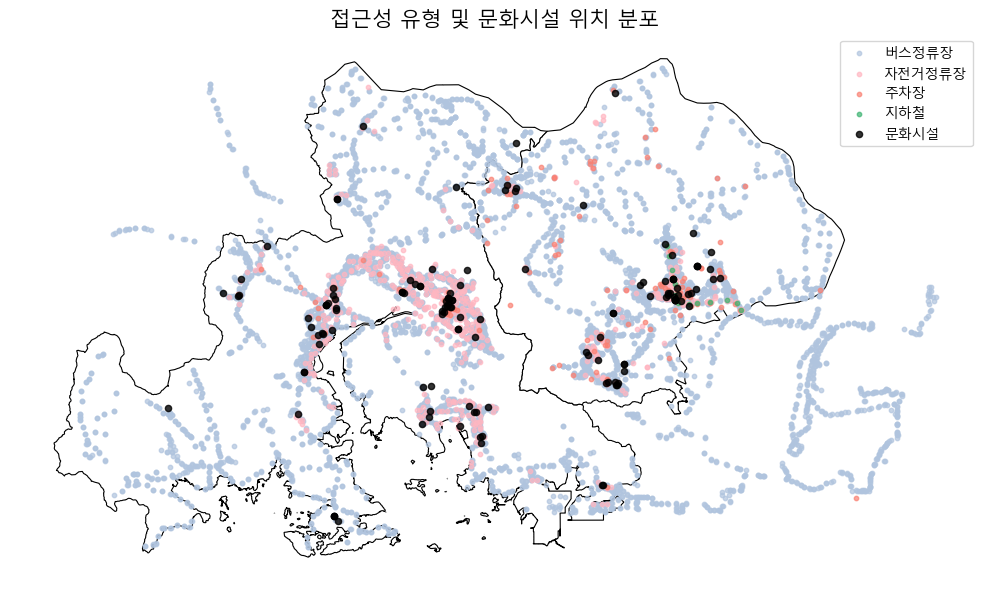

In [74]:
color_dict = {
    '버스정류장': 'lightsteelblue',
    '자전거정류장': 'lightpink',
    '지하철': 'mediumseagreen',
    '주차장': 'salmon'
}

fig, ax = plt.subplots(figsize=(10, 10))

gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)

# 유형별 점 찍기
for access_type, group in gdf_access.groupby('접근성'):
    group.plot(ax=ax, markersize=10, color=color_dict.get(access_type, 'gray'), label=access_type, alpha=0.7)

gdf_facility.plot(ax=ax, markersize=20, color='black', label='문화시설', alpha=0.8)


# 레이아웃
ax.set_title('접근성 유형 및 문화시설 위치 분포', fontsize=15)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()


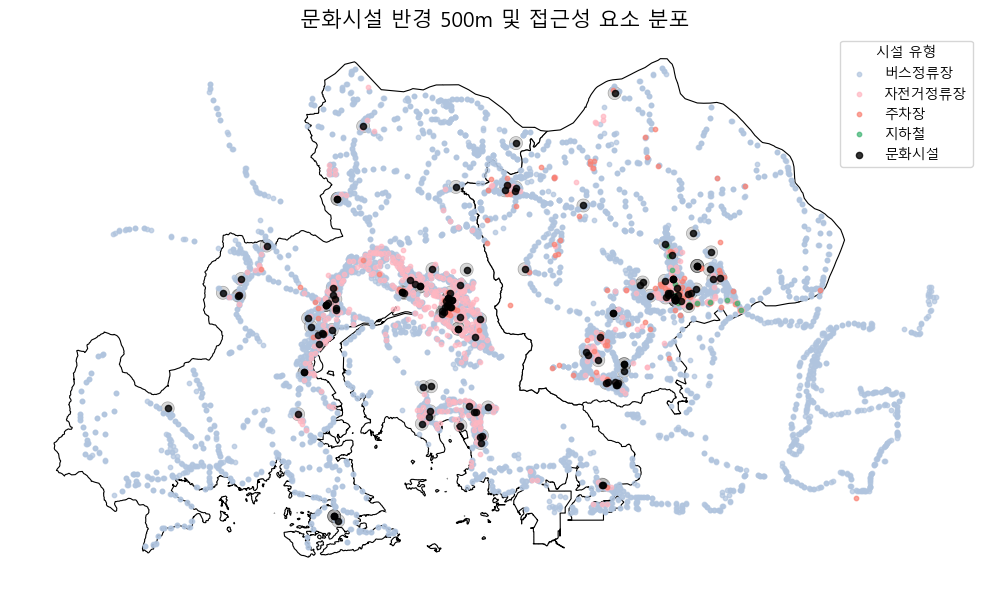

In [75]:
#문화시설 반경 500 M

gdf_facility_proj = gdf_facility.to_crs(epsg=5179)

gdf_facility_proj['buffer'] = gdf_facility_proj.buffer(500)

gdf_buffer = gpd.GeoDataFrame(gdf_facility_proj[['buffer']], geometry='buffer', crs='EPSG:5179')
gdf_buffer = gdf_buffer.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)

gdf_buffer.plot(ax=ax, color='gray', alpha=0.3, edgecolor='black', linewidth=0.5)

for access_type, group in gdf_access.groupby('접근성'):
    group.plot(ax=ax, markersize=10, color=color_dict.get(access_type, 'gray'), label=access_type, alpha=0.7)

gdf_facility.plot(ax=ax, markersize=20, color='black', label='문화시설', alpha=0.8)

ax.set_title('문화시설 반경 500m 및 접근성 요소 분포', fontsize=15)
ax.legend(title='시설 유형')
ax.axis('off')
plt.tight_layout()
plt.show()

In [77]:
gdf_facility_proj = gdf_facility.to_crs(epsg=5179)
gdf_facility_proj['buffer'] = gdf_facility_proj.buffer(500)

gdf_access_proj = gdf_access.to_crs(epsg=5179)

gdf_buffer = gpd.GeoDataFrame(gdf_facility_proj[['buffer']], geometry='buffer', crs='EPSG:5179')
gdf_buffer['facility_id'] = gdf_buffer.index

joined = gpd.sjoin(gdf_access_proj, gdf_buffer, how='inner', predicate='within')

access_counts = joined.groupby(['facility_id', '접근성']).size().unstack(fill_value=0).reset_index()

result = gdf_facility.reset_index().merge(access_counts, left_index=True, right_on='facility_id', how='left')
result = result.fillna(0)  

result[['구분', '버스정류장', '자전거정류장', '지하철', '주차장']]


,구분,버스정류장,자전거정류장,지하철,주차장
NaN,문화예술회관,0.0,0.0,0.0,0.0
NaN,문화예술회관,0.0,0.0,0.0,0.0
0.0,문화예술회관,26.0,5.0,0.0,3.0
NaN,문화예술회관,0.0,0.0,0.0,0.0
1.0,미술관,7.0,4.0,0.0,0.0
...,...,...,...,...,...
121.0,박물관,9.0,0.0,0.0,0.0
NaN,박물관,0.0,0.0,0.0,0.0
122.0,박물관,8.0,0.0,0.0,0.0
123.0,박물관,2.0,0.0,0.0,0.0


In [83]:
result

,index,Unnamed: 0,시군구,소재지,Latitude,Longitude,구분,geometry,facility_id,버스정류장,자전거정류장,주차장,지하철
NaN,2,10,김해시,김해시 김해대로 2062 (내동),35.242477,128.863187,문화예술회관,POINT (128.86319 35.24248),0,0.0,0.0,0.0,0.0
NaN,3,13,창원시,창원시 진해구 진해대로 325 (태백동),35.169833,128.666084,문화예술회관,POINT (128.66608 35.16983),1,0.0,0.0,0.0,0.0
0.0,4,14,창원시,창원시 마산회원구 삼호로 135,35.225855,128.577258,문화예술회관,POINT (128.57726 35.22585),2,26.0,5.0,3.0,0.0
NaN,5,15,창원시,창원시 의창구 중앙로 181 (용호동),35.234087,128.681811,문화예술회관,POINT (128.68181 35.23409),3,0.0,0.0,0.0,0.0
1.0,6,3,김해시,김해시 진례면 진례로 275-51,35.250474,128.744954,미술관,POINT (128.74495 35.25047),4,7.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121.0,141,5,김해시,김해시 가야의길 126 (대성동),35.237406,128.873746,박물관,POINT (128.87375 35.23741),131,9.0,0.0,0.0,0.0
NaN,142,7,창원시,창원시 진해구 중원로 1,35.144006,128.658285,박물관,POINT (128.65828 35.14401),132,0.0,0.0,0.0,0.0
122.0,143,17,창원시,창원시 진해구 중원동로 52 (제황산동),35.148911,128.663991,박물관,POINT (128.66399 35.14891),133,8.0,0.0,0.0,0.0
123.0,144,20,김해시,김해시 인제로 197 (어방동),35.250387,128.901177,박물관,POINT (128.90118 35.25039),134,2.0,0.0,0.0,0.0


In [84]:
no_access = result[
    (result['버스정류장'] == 0) &
    (result['자전거정류장'] == 0) &
    (result['지하철'] == 0)
]


In [85]:
no_access[['시군구', '소재지', '구분', 'Latitude', 'Longitude']]

,시군구,소재지,구분,Latitude,Longitude
NaN,김해시,김해시 김해대로 2062 (내동),문화예술회관,35.242477,128.863187
NaN,창원시,창원시 진해구 진해대로 325 (태백동),문화예술회관,35.169833,128.666084
NaN,창원시,창원시 의창구 중앙로 181 (용호동),문화예술회관,35.234087,128.681811
15.0,창원시,경상남도 창원시 마산합포구 구산면 반동리 산 121-1,공연장,35.080286,128.584380
NaN,창원시,경상남도 창원시 진해구 덕산동 584-1번지,공연장,35.142742,128.690895
NaN,창원시,경상남도 창원시 의창구 명서동 199-2 대호상가지하1호,공연장,35.242984,128.648596
NaN,창원시,경상남도 창원시 의창구 용호동 2번지,공연장,35.229602,128.683335
NaN,김해시,경상남도 김해시 부원동 1043번지,유원시설업(기타),35.225072,128.883257
NaN,창원시,경상남도 창원시 의창구 봉림동 713-4,유원시설업(기타),35.250455,128.667208
NaN,창원시,경상남도 창원시 의창구 팔용동 30-3 삼성홈플러스,유원시설업(기타),35.234119,128.643685


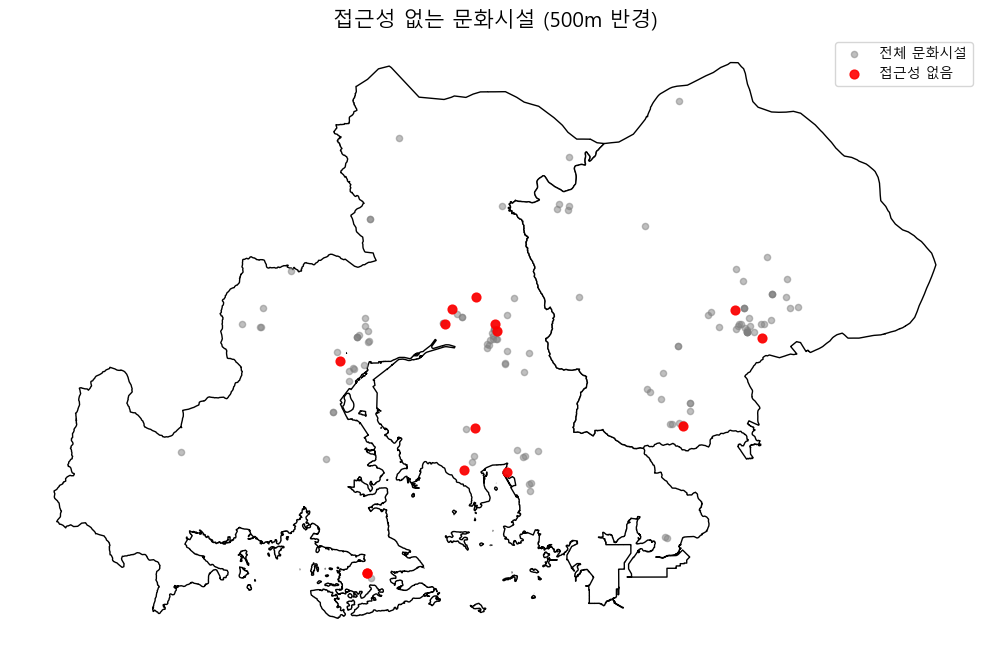

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black')

gdf_facility.plot(ax=ax, color='gray', markersize=20, label='전체 문화시설', alpha=0.5)

no_access_gdf = gpd.GeoDataFrame(no_access, geometry='geometry', crs='EPSG:4326')
no_access_gdf.plot(ax=ax, color='red', markersize=40, label='접근성 없음', alpha=0.9)

# 스타일
ax.set_title('접근성 없는 문화시설 (500m 반경)', fontsize=15)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()


In [82]:
result.to_csv("access_result.csv")

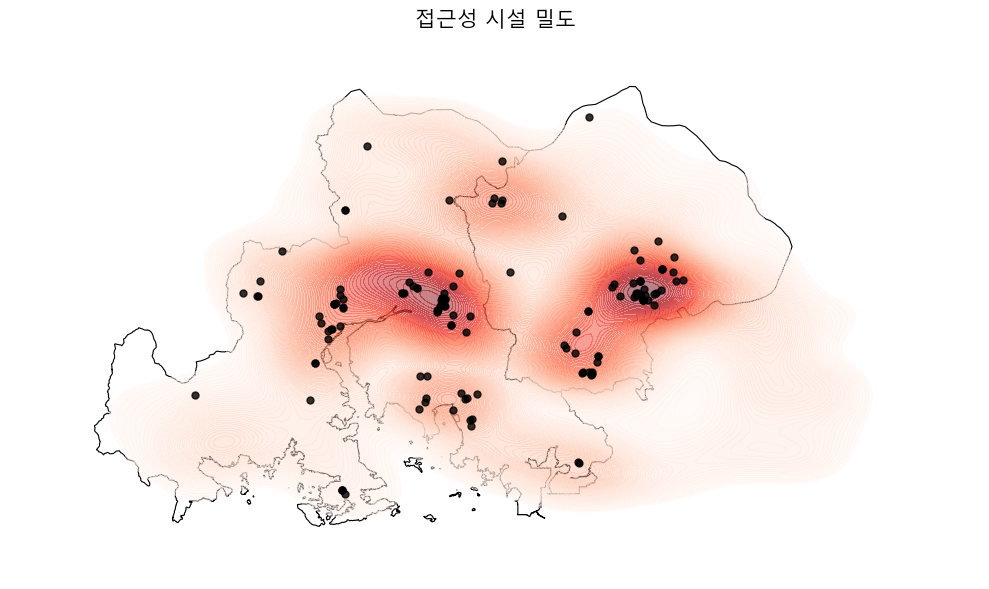

In [80]:
x = gdf_access['geometry'].x
y = gdf_access['geometry'].y

fig, ax = plt.subplots(figsize=(10, 10))

gdf_map_filtered.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)

sns.kdeplot(x=x, y=y,
            ax=ax,
            cmap='Reds',      
            fill=True,       
            alpha=0.5,   
            thresh=0.05,    
            levels=100)      

gdf_facility.plot(ax=ax, color='black', markersize=25, label='문화시설', alpha=0.8)


ax.set_title('접근성 시설 밀도', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()

### 수요 대비 공급 분석
 - 인구 수 대비 문화시설의 분포

In [88]:
df_ppl = pd.read_csv(ppl, encoding='euc-kr')
df_ppl

,연도,시도군,분기,주중/말,시간대,성별,인구수
0,2024,거제시,1분기,평일,새벽,여,13377818
1,2024,거제시,1분기,평일,새벽,남,14779832
2,2024,거제시,1분기,평일,야간,여,13335206
3,2024,거제시,1분기,평일,야간,남,14814852
4,2024,거제시,1분기,평일,오전,여,13204265
...,...,...,...,...,...,...,...
1403,2024,합천군,4분기,주말,야간,남,714063
1404,2024,합천군,4분기,주말,오전,남,810127
1405,2024,합천군,4분기,주말,오전,여,739792
1406,2024,합천군,4분기,주말,오후,여,769995


In [92]:
df_ppl2 = pd.read_csv(ppl_c)
df_ppl2

,시군구명,접근성 변수명,남,여
0,김해시,세대인구_외국인,"15,585","5,840"
1,김해시,세대인구_성별,"269,755","263,904"
2,김해시,거주인구_총인구,"285,340","269,744"
3,김해시,연령별_100세 이상인구,4,31
4,김해시,연령별_10대미만 인구,"20,507","19,172"
5,김해시,연령별_10대인구,"30,468","28,953"
6,김해시,연령별_20대인구,"33,048","27,032"
7,김해시,연령별_30대인구,"33,134","30,200"
8,김해시,연령별_40대인구,"45,884","45,920"
9,김해시,연령별_50대인구,"51,694","51,022"
